In [1]:
# importing needed libs

import pandas as pd
import pandahouse
from scipy import stats
import seaborn as sns

In [2]:
# connecting needed data

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20241220'
}

query = """
SELECT
  user_id,
  exp_group,
  ROUND(likes / views, 2) AS ctr
FROM
  (
    SELECT
      user_id,
      exp_group,
      sum(action = 'view') AS views,
      sum(action = 'like') AS likes
    FROM
      simulator_20241220.feed_actions
    WHERE
      toDate(time) BETWEEN '2024-11-15'
      AND '2024-11-21'
      AND exp_group in (2, 3)
    GROUP BY
      user_id,
      exp_group
  )"""

df = pandahouse.read_clickhouse(query, connection=connection)

df.head()

,user_id,exp_group,ctr
0,115383,3,0.15
1,10326,3,0.18
2,123580,3,0.20
3,131473,2,0.19
4,23985,2,0.27


In [3]:
# deviding the data into two groups by exp_group column

second_group_ctr = df[df.exp_group == 2].ctr
third_group_ctr = df[df.exp_group == 3].ctr

In [4]:
# making a list with p-values from checking two groups using T-test

p_value_list = []
for _ in range(10000):
    second_group_ctr_sample = second_group_ctr.sample(500, replace=False)
    third_group_ctr_sample = third_group_ctr.sample(500, replace=False)
    p_value = stats.ttest_ind(second_group_ctr_sample,
                    third_group_ctr_sample,
                    equal_var=False
    )[1]
    p_value_list.append(p_value)

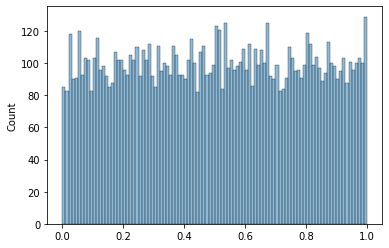

In [5]:
# making a histogram to see visually the p-value distribution

p_value_hist = sns.histplot(
    data=p_value_list,
    alpha=0.5,
    kde=False,
    bins=100
)

The distribution is uniform as in should be for right working split system

In [6]:
# checking the FPR

sum(pd.Series(p_value_list) < 0.05) / 10000

0.0466

**Since the result is less than 0.05, then we can consider the split system as working properly**